<a href="https://colab.research.google.com/github/jeniferwerthman/AdvAILSTM/blob/main/Copy_of_LSTMStock_Take2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pandas_datareader as pdr
import os
import matplotlib.pyplot as mplot
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import numpy as np
import altair as alt 
import tensorflow as tf 
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [3]:
#Import Data 
stockDf = pd.read_csv('AAPL.csv',delimiter=',')
stockDf['openChange'] = stockDf.Open.pct_change()
stockDf['closeChange'] = stockDf.Close.pct_change()
stockDf['weekday_num'] = pd.DatetimeIndex(stockDf['Date']).weekday
stockDf['month'] = pd.DatetimeIndex(stockDf['Date']).month
stockDf['day'] = pd.DatetimeIndex(stockDf['Date']).day
stockDf['year'] = pd.DatetimeIndex(stockDf['Date']).year
stockDf['display'] = stockDf["month"].map(str)+ "-" + stockDf["year"].map(str)

# Select features (columns) to be involved intro training and predictions
cols = list(stockDf)[1:7]

# Extract dates (will be used in visualization)
datelist_train = list(stockDf['Date']) 
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(stockDf.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (254, 14)
All timestamps == 254
Featured selected: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [ ]:
[[stockDf]]

[[            Date         Open         High         Low        Close  \
  0     2010-06-29     3.800000     5.000000    3.508000     4.778000   
  1     2010-06-30     5.158000     6.084000    4.660000     4.766000   
  2     2010-07-01     5.000000     5.184000    4.054000     4.392000   
  3     2010-07-02     4.600000     4.620000    3.742000     3.840000   
  4     2010-07-06     4.000000     4.000000    3.166000     3.222000   
  ...          ...          ...          ...         ...          ...   
  2973  2022-04-20  1030.000000  1034.000000  975.250000   977.200012   
  2974  2022-04-21  1074.729980  1092.219971  996.419983  1008.780029   
  2975  2022-04-22  1014.909973  1034.849976  994.000000  1005.049988   
  2976  2022-04-25   978.969971  1008.619995  975.299988   998.020020   
  2977  2022-04-26   995.429993  1000.000000  875.000000   876.419983   
  
          Adj Close    Volume  openChange  closeChange  weekday_num  month  day  \
  0        4.778000  93831500         

In [4]:
(alt.Chart(stockDf).mark_line().encode(x='Date', y='Close').properties(height=400, width=500))

alt.Chart(...)

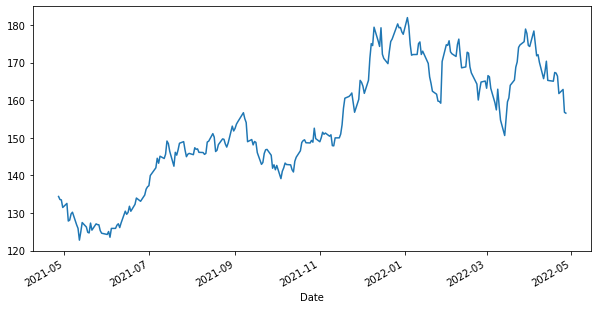

In [5]:
stockDf.Date = pd.to_datetime(stockDf.Date, format = '%Y/%m/%d')
plot_Stock = stockDf.set_index('Date') 
plot_Stock['Close'].plot(figsize=(10,5))

In [ ]:
closedChart = (alt.Chart(stockDf).mark_line().encode(x='Date', y='closeChange', color=alt.value('black')).properties(height=400, width=2000))
openChart = (alt.Chart(stockDf).mark_line().encode(x='Date', y='openChange', color=alt.value('green')).properties(height=400, width=2000))
closedChart+openChart

In [ ]:
open = (alt.
         Chart(stockDf).
         mark_line().
         encode(x=alt.X('display', sort=['year', 'month']), y='max(Close)', color='year').
         properties(height=400, width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.year==2018).
         mark_line().
         encode(x=alt.X('display', sort=['year', 'month']), y='max(Close)', color='year').
         properties(height=200, width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.year==2018).
         mark_line().
         encode(x=alt.X('week(Date):T', sort=['year', 'month']), y='max(Close)', color='year').
         properties(height=200  , width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).
         mark_line().
         encode(x=alt.X('month(Date):T'), y='max(closeChange)', color='year').
         properties(height=200  , width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.month==3).
         mark_line().
         encode(x=alt.X('day', sort=['year', 'month']), y='max(Volume)', color='year').
         properties(height=200  , width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.month==3).
         mark_line().
         encode(x=alt.X('day', sort=['year', 'month']), y='max(closeChange)', color='year').
         properties(height=200  , width=500))
open

In [6]:

print('Featured selected: {}'.format(cols))
stockDf = stockDf[cols].astype(str)
for i in cols:
    for j in range(0, len(stockDf)):
        stockDf[i][j] = stockDf[i][j].replace(',', '')

stockDf = stockDf.astype(float)

# Using multiple features (predictors)
newDf = stockDf.to_numpy()
myDs = stockDf.to_numpy()
myDs = myDs.astype('float32')
print('Shape of training set == {}.'.format(newDf.shape))
newDf


Featured selected: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Shape of training set == (254, 6).


array([[1.35009995e+02, 1.35410004e+02, 1.34110001e+02, 1.34389999e+02,
        1.33595963e+02, 6.60158000e+07],
       [1.34309998e+02, 1.35020004e+02, 1.33080002e+02, 1.33580002e+02,
        1.32790741e+02, 1.07760100e+08],
       [1.36470001e+02, 1.37070007e+02, 1.32449997e+02, 1.33479996e+02,
        1.32691345e+02, 1.51101000e+08],
       ...,
       [1.61119995e+02, 1.63169998e+02, 1.58460007e+02, 1.62880005e+02,
        1.62880005e+02, 9.60464000e+07],
       [1.62250000e+02, 1.62339996e+02, 1.56720001e+02, 1.56800003e+02,
        1.56800003e+02, 9.56232000e+07],
       [1.55910004e+02, 1.59789993e+02, 1.55380005e+02, 1.56570007e+02,
        1.56570007e+02, 8.75112220e+07]])

In [ ]:
#Creating a new Dataframe & Dataset with subset of records 

#Parameters
#limitList = False
#fromRecord = 50
#toRecord = 100

#newDf = pd.DataFrame().assign(Open=stockDf['Open'], Close=stockDf['Close'], Volume=stockDf['Volume'])
#if limitList:
  #newDf = newDf.loc[fromRecord:toRecord]
#myDs = newDf.to_numpy()
#myDs = myDs.astype('float32')
#newDf.head(5)

,Open,Close,Volume
0,3.800,4.778,93831500
1,5.158,4.766,85935500
2,5.000,4.392,41094000
3,4.600,3.840,25699000
4,4.000,3.222,34334500


In [7]:
#Parameters
trainingSet = .70
featureRange1 = 0
featureRange2 = 1
newShape1 = -1
newShape2 = 1 

myDs = np.reshape(myDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
myDs = scaler.fit_transform(myDs)
trainingSize = int(len(myDs) * trainingSet)
testingSize = int(len(myDs) - trainingSize)
trainData, testData = myDs[0:trainingSize,:], myDs[testingSize:len(myDs),:]

In [8]:
#Parameters
batchSize = 5
timeSteps = 1
#Batch Data for optimization and accuracy
#This creates batches with 1 to N records.  
#X - Each Batch starts with the next item i in the list and contains specified number of additional items
#Y - Contains the last item in each batch "L" or first "F" or previious "P" or next "N"
def batchData(data, size, indexAlignment = "L"):
    X, Y = [], [] 
    for i in range(len(data) - size - 1): 
        X.append(data[i:(i + size), 0])
         
        if indexAlignment == "N":
          Y.append(data[i + size, 0])
        elif indexAlignment == "L":
          Y.append(data[i + size - 1, 0])
        elif indexAlignment == "P":  
          Y.append(data[i-1, 0])
        else:
          Y.append(data[i, 0]) 

    return np.array(X), np.array(Y)

#Catch Batches for Accuracy and Optimization
X_train, Y_train = batchData(trainData, batchSize, "L")
X_test, Y_test = batchData(testData, batchSize,"L")

In [9]:
#Reshape data to normalize it [samples, time steps, features]
print("take 2")
print('X_Train[0] (Samples): ' + str(X_train.shape[0]))
print('X_Train[1] (Features): ' + str(X_train.shape[1]))
X_train = np.reshape(X_train, (X_train.shape[0], timeSteps, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], timeSteps, X_test.shape[1]))
print("take 2")
print('X_Train[0] (Samples): ' + str(X_train.shape[0]))
print('X_Train[1] (Features): ' + str(X_train.shape[1]))

take 2
X_Train[0] (Samples): 1060
X_Train[1] (Features): 5
take 2
X_Train[0] (Samples): 1060
X_Train[1] (Features): 1


In [10]:
#Parameters
verboseAmt = 1
epochCnt = 25
shuffleData = False
dropOut = 0.2
lstmActivation = 'relu'
activationLayer = 'linear'
lossType = 'mean_squared_error'
optimizerType = 'adam'
lstmUnits = 50
lstmMultipleLayers = False

model = Sequential()

if lstmMultipleLayers:
  model.add(LSTM(units = lstmUnits, return_sequences = True, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize)))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits))
  model.add(Dropout(dropOut))
else:
  model.add(LSTM(units = lstmUnits, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize))) 
  model.add(Dropout(dropOut))

model.add(Dense(1, activation = activationLayer))
model.compile(loss = lossType, optimizer = optimizerType)
modelFit = model.fit(X_train, Y_train, epochs = epochCnt, batch_size = batchSize, validation_data = (X_test, Y_test), verbose = verboseAmt, shuffle = False)
model.summary()

Epoch 1/25
212/212 [==============================] - 2s 5ms/step - loss: 0.0141 - val_loss: 0.0036
Epoch 2/25
212/212 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 5.1055e-04
Epoch 3/25
212/212 [==============================] - 1s 4ms/step - loss: 0.0014 - val_loss: 1.9221e-04
Epoch 4/25
212/212 [==============================] - 1s 4ms/step - loss: 9.9368e-04 - val_loss: 1.2836e-04
Epoch 5/25
212/212 [==============================] - 1s 4ms/step - loss: 8.1817e-04 - val_loss: 5.6266e-05
Epoch 6/25
212/212 [==============================] - 1s 3ms/step - loss: 7.1282e-04 - val_loss: 7.8394e-05
Epoch 7/25
212/212 [==============================] - 1s 3ms/step - loss: 7.0380e-04 - val_loss: 6.0591e-05
Epoch 8/25
212/212 [==============================] - 1s 4ms/step - loss: 6.7690e-04 - val_loss: 9.3779e-06
Epoch 9/25
212/212 [==============================] - 1s 4ms/step - loss: 5.4457e-04 - val_loss: 6.4584e-05
Epoch 10/25
212/212 [=======================

In [11]:
#Predictions
train_predict = model.predict(X_train)
Y_trained_predict = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)
Y_test_predict = scaler.inverse_transform(test_predict)

Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

In [12]:
print('X_train: ' + str(len(X_train)))
print('X_test: ' + str(len(X_test)))
print('Y_train: ' + str(len(Y_train)))
print('Y_test: ' + str(len(Y_test)))
print('')
print('train_predict: ' + str(len(train_predict)))
print('Y_trained_predict: ' + str(len(Y_trained_predict)))
print('test_predict: ' + str(len(test_predict)))
print('Y_test_predict: ' + str(len(Y_test_predict)))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:' + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))

X_train: 1060
X_test: 1060
Y_train: 1
Y_test: 1

train_predict: 1060
Y_trained_predict: 1060
test_predict: 1060
Y_test_predict: 1060
Shape of Y_train:1
Shape of Y_train:1
Shape of Y_train:1
Shape of Y_train:1


In [13]:
#inverse the inverse
Y_trained_predict = scaler.inverse_transform(train_predict)
Y_test_predict = scaler.inverse_transform(test_predict)

s1 = Y_test.shape[0]
s2 = Y_test.shape[1]
Y_test = Y_test.reshape(s2,s1)
s1 = Y_train.shape[0]
s2 = Y_train.shape[1]
Y_train = Y_train.reshape(s2,s1)

In [14]:
#Calculate Accuracy
train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_trained_predict))
test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_predict))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
1701176.6237109008 

Test RMSE is: 
1805444.4954577265


In [15]:
#Actual vs Predicted Data
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_trained_predict, Y_test_predict)

result_df = pd.DataFrame()
result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat
result_df.head()

,Actual_Y,Predicted_Y
0,1.335960e+02,2.590945e+05
1,6.601580e+07,6.889646e+07
2,1.343100e+02,-6.235238e+05
3,1.350200e+02,-4.712609e+05
4,1.330800e+02,-4.703989e+05


Text(0, 0.5, 'Value of Stock')

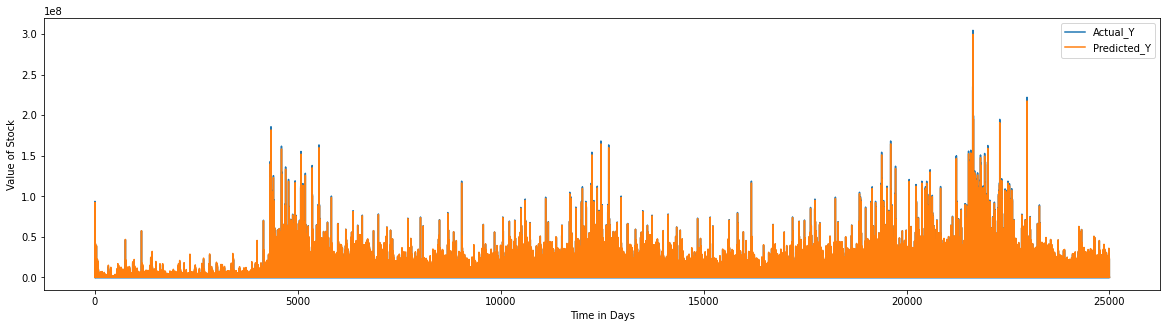

In [ ]:
#Actual vs Predicted Graph
result_df.plot(figsize=(20,5))
mplot.xlabel('Time in Days')
mplot.ylabel('Value of Stock')